<a href="https://colab.research.google.com/github/vicmcl/ml-laptime/blob/main/ml_laptime/notebook/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Import**

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import xgboost as xgb

from pathlib import Path
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from src.features import preprocess_data
from src.utils import laps_with_incident, remove_incidents, remove_pitstops

ModuleNotFoundError: No module named 'xgboost'

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install fastf1 package
    !pip install -U -q fastf1

    # Mount Drive
    from google.colab import drive
    drive.flush_and_unmount()
    drive.mount('/content/drive')
    DRIVE_PATH = Path("/content/drive/MyDrive/")
    ML_PATH = DRIVE_PATH / "Projects" / "laptime-simulation"

else:
    ML_PATH = Path("data")

Mounted at /content/drive


In [5]:
data_paths = glob.glob(str(ML_PATH / "races_*.pkl"))
data = {}

for path in data_paths:
    with open(path, "rb") as f:
        data[int(path.split(".")[0][-4:])] = pickle.load(f)

## **Feature engineering**

In [309]:
si = SimpleImputer()

gp = 'Spanish Grand Prix'
df = pd.DataFrame()

for year in sorted(list(data.keys())):
    preprocessed_data = preprocess_data(gp, year)
    for col in preprocessed_data.columns:
        preprocessed_data[col] = si.fit_transform(preprocessed_data[[col]])
    df = pd.concat([df, preprocessed_data])

df = df.dropna(subset='LapTime')
df = df.query("LapNumber > 1")
df = df.reset_index(drop=True)
df['LagLapTime'] = df['LapTime'].shift(1)

## **Training**

In [310]:
df_train = df.query("Season != 2021")

speed_trap = select_speed_trap(df_train)
df_train = filter_speed_trap(df_train, speed_trap)
print(f"Selected speed trap: {speed_trap}")

Selected speed trap: SpeedI2


In [311]:
FEATURES = list(df_train.columns)
FEATURES.remove('LapTime')
TARGET = 'LapTime'

In [312]:
laps_to_predict = 3
tss = TimeSeriesSplit(test_size=laps_to_predict)

param_grid = {
    'n_estimators': [300, 500, 1000],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [3, 4, 5],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

X_train = df_train[FEATURES]
y_train = df_train[TARGET]

model = xgb.XGBRegressor(random_state=42)

grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=tss,
        scoring='neg_mean_squared_error',
        verbose=1,
        n_jobs=-1
)

grid_search.fit(X_train, y_train, verbose=100)

# Get the best model
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


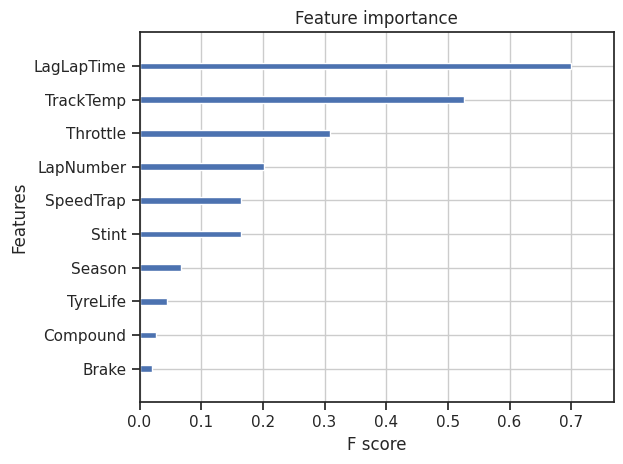

In [339]:
importance = best_model.get_booster().get_score(importance_type='gain')
xgb.plot_importance(best_model, importance_type='gain', values_format="")
plt.tight_layout()

In [314]:
errors = []
scores = []
predicted_laps = []
df_2021 = df.query("Season == 2021")
df_2021 = filter_speed_trap(df_2021, speed_trap)

for start_lap in range(0, 48, laps_to_predict):
    real_time_model = best_model
    df_retrain = pd.concat([df_train, df_2021[:start_lap]], axis=0)
    df_test = df_2021[start_lap:start_lap + laps_to_predict]

    X_retrain = df_retrain[FEATURES]
    y_retrain = df_retrain[TARGET]

    real_time_model.fit(
        X_retrain, y_retrain, verbose=100, xgb_model=real_time_model
    )
    preds = real_time_model.predict(df_test[FEATURES])
    predicted_laps += preds.tolist()
    score_test = mean_squared_error(df_test['LapTime'], preds, squared=False)
    errors += (df_test['LapTime'] - preds).to_list()
    scores.append(score_test)

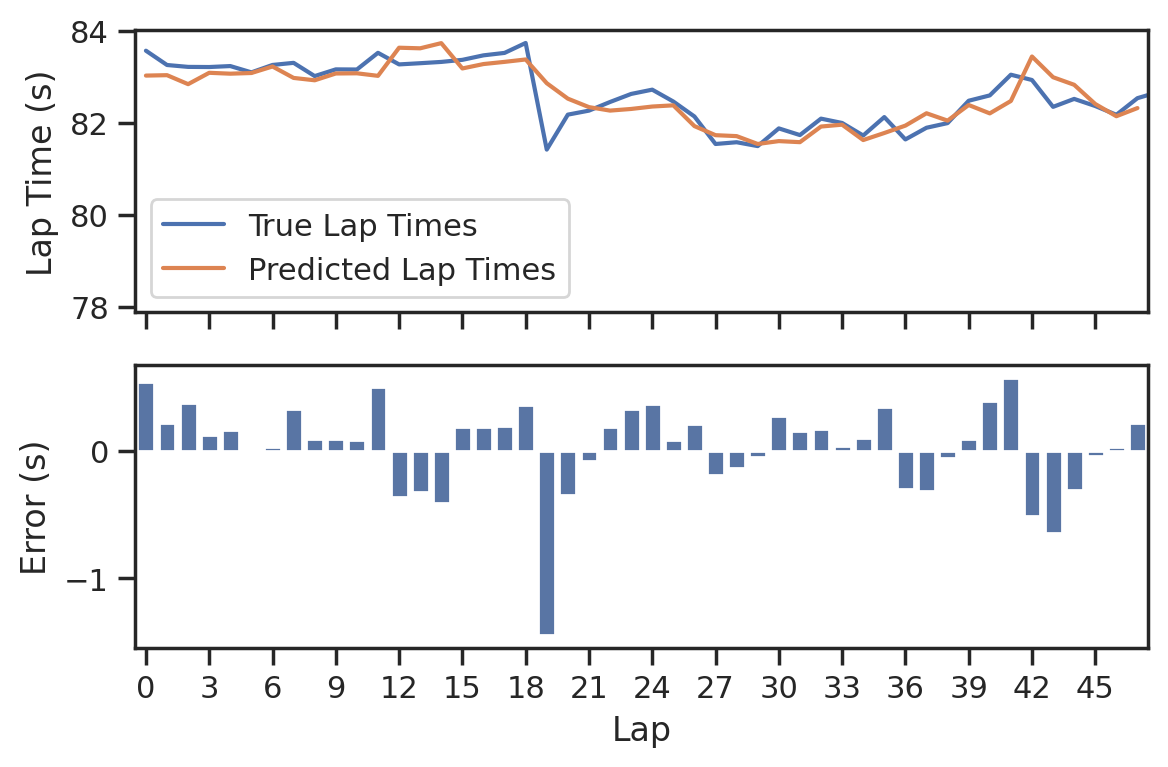

In [337]:
sns.set_style("ticks")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 4), sharex=True, dpi=200)
sns.lineplot(df_2021['LapTime'].values, ax=ax1, label='True Lap Times')
sns.lineplot(predicted_laps, ax=ax1, label='Predicted Lap Times')
sns.barplot(errors, ax=ax2, label='Error')
ax1.set_ylabel('Lap Time (s)')
ax2.set_ylabel('Error (s)')
ax2.set_xlabel('Lap')
locs, labels = plt.xticks()
plt.xticks(locs[::3], labels[::3])
plt.tight_layout()

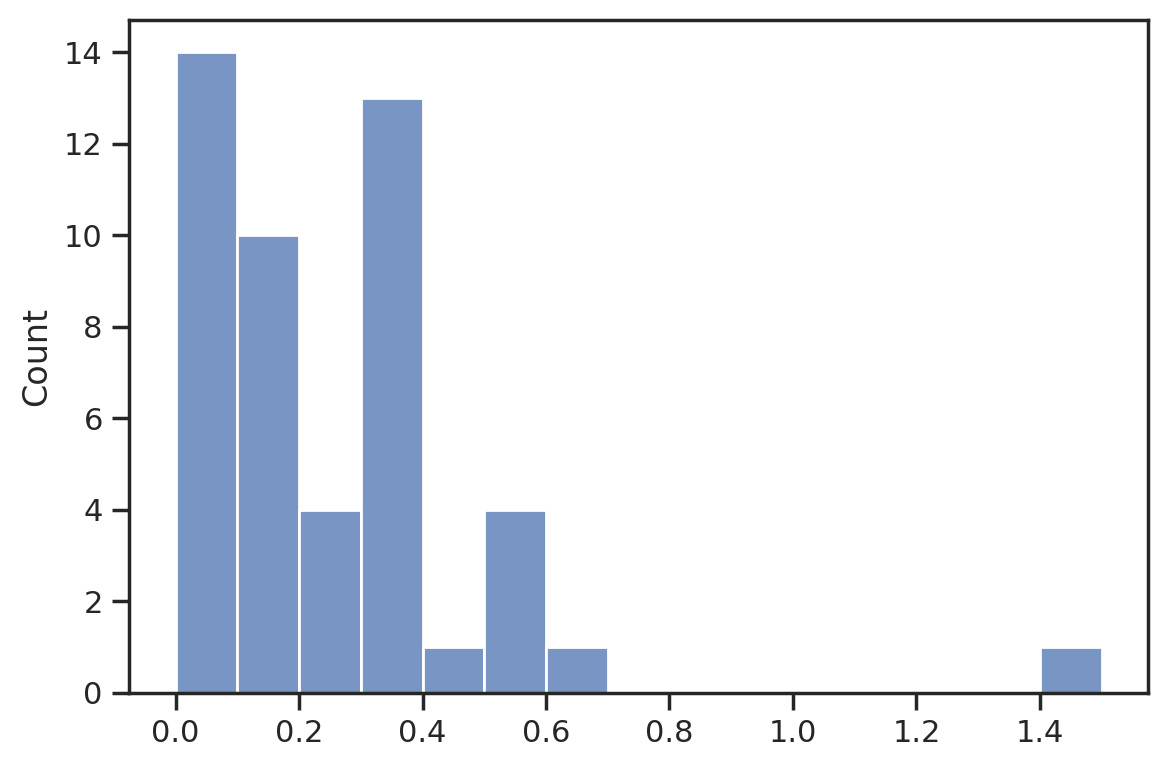

In [338]:
mae = np.abs(errors)
fig = plt.figure(figsize=(6, 4), dpi=200)
sns.histplot(mae, binwidth=0.1, binrange=(0, 1.5))
plt.tight_layout()

In [317]:
np.median(mae)

0.20211169433594023